CS524: Introduction to Optimization Lecture 30
======================================

## Michael Ferris<br> Computer Sciences Department <br> University of Wisconsin-Madison 

## November 13, 2023
--------------


In [1]:
%load_ext gams.magic
m = gams.exchange_container

In [2]:
%%gams
sets i  observation number /1930*1962 /,
     cols  index of all variables / "Rain0","Temp1","Rain1","Temp2","Rain2","Temp3","Rain3","Temp4", "Yield" /,
     n(cols)  index of independent variables / "Rain0","Temp1","Rain1","Temp2","Rain2","Temp3","Rain3","Temp4" /;

table dat(i,cols)
* include a file from the current directory to fill out this table
$ondelim
$include iowheat.csv
$offdelim
;

parameter means(cols), stddev(cols);
means(cols) = sum(i, dat(i,cols))/card(i);
stddev(cols) = sqrt(sum(i, sqr(dat(i,cols)-means(cols)))/card(i));

parameter sdat(i,cols);
sdat(i,cols) = (dat(i,cols) - means(cols))/stddev(cols);

Huber is a hybrid of least-squares and $\ell_1$. Behaves like least squares ($\ell_2$) for $r$ near 0, otherwise like $\ell_1$. Define

$$
\rho_H(r) =
  \begin{cases}
    \frac{1}{2}r^2       & \quad |r|\leq\sigma\\
    \sigma|r|-\frac{1}{2}\sigma^2  & \quad |r|\geq\sigma.
  \end{cases}
$$

Here $\sigma>0$ is a given parameter. The function $\rho$ is $C^1$ but not $C^2$ (i.e. there is a discontinuity in the second derivative at $|r|=\sigma$.) Still, an NLP solver will usually work.

The Huber regression problem is thus:
$$ \min_{x} L_H(x) := \displaystyle\sum_{i=1}^{m} \rho_H(a_i^Tx-y_i)
$$

Surprisingly, can also formulate Huber estimation as a QP! We omit the details; the derivation requires duality. The dual formulation is:

$$
\min_{w}\frac{1}{2}w^Tw+y^Tw \text{  s.t. } A^Tw=0, -\sigma \leq w_i \leq \sigma, i=1,\ldots,m.
$$

The marginal variables for the constraint $A^Tw=0$ are identical to the solution $x$ of the Huber problem in primal form.
Constraints, for example may require that some components of $x$ must be nonegative. Then the problem becomes a bona fide optimization problem.

In [3]:
%%gams
$title Linear Regression with Huber (scaling data)
option limrow=0, limcol=0;
$Ontext

This example solves linear regression with Huber modeled as QP.

Use the data given as iowheat.csv.
Formulate both primal and dual versions of the model

$Offtext

$if not set sigma $set sigma 1.0
parameter sigma "cutoff for quadratic penalty" /%sigma%/;

variables  obj  objective value
           r(i) approximate residual
           t(i) residual l_1 error
           x(n)   estimates;

equations  upp(i), low(i), huber;

upp(i)..   sdat(i,"Yield") - sum(n, sdat(i,n)*x(n)) - r(i) =l= t(i);

low(i)..   -t(i) =l= sdat(i,"Yield") - sum(n, sdat(i,n)*x(n)) - r(i);

huber..  obj =e= 1/2*sum(i, sqr(r(i))) + sigma*sum(i, t(i));

model hubmod / huber, low, upp /;

x.l(n) = 1; 
solve hubmod min obj using qcp;
* display x.l, obj.l; 

Solver Status      Model Status  Objective #equ #var Model Type  Solver  \
0    Normal (1)  OptimalLocal (2)     8.0013   67   75        QCP  CONOPT   

  Solver Time  
0        0.01

In [4]:
display(m['x'].records[['n','level']])

n     level
0  Rain0  0.092815
1  Temp1 -0.107536
2  Rain1 -0.187021
3  Temp2 -0.049339
4  Rain2  0.342450
5  Temp3 -0.376443
6  Rain3  0.158645
7  Temp4 -0.012639

# Tradeoff: compressed sensing

- Often wish to find "sparse" solutions to least-squares problems, in which most of the elements of the solution $x$ are zero. 
- We are willing to sacrifice a little goodness of fit (the objective) in order to find an approximate solution with a small number of nonzeros. 
- The nonzeros are called "explanatory variables;" we wish to find the set of explanatory variables of a given size that best explains the observations.
- Could do this explicity by allowing only a certain number of $x$ components to be nonzero, using binary selector variables $s_i, i=1,2,...,n$, with constraints $-Ms_i \leq x_i \leq Ms_i$ and $\sum s_i\leq k$, where $k$ is the maximum number of nonzero components (this is an miqcp)

In [5]:
%%gams
* Now do feature selection
option miqcp=cplex;

binary variables s(n) 'selection of feature';

scalar bigM;
bigM = 1.2*smax(n, abs(x.l(n)));

equations sparse, uselo(n), useup(n);
scalar k "count" /3/;

sparse.. sum(n, s(n)) =l= k;
uselo(n).. x(n) =g= -bigM*s(n);
useup(n).. x(n) =l= bigM*s(n);

model feature / hubmod, sparse, uselo, useup /;
feature.optcr = 1e-4;
solve feature using miqcp min obj;

Solver Status        Model Status  Objective #equ #var Model Type Solver  \
0    Normal (1)  Optimal Global (1)     8.3971   84   83      MIQCP  CPLEX   

  Solver Time  
0       0.015

In [6]:
display(m.data['x'].records[['n','level']])

n     level
0  Rain0  0.000000
1  Temp1  0.000000
2  Rain1  0.000000
3  Temp2  0.000000
4  Rain2  0.403713
5  Temp3 -0.350088
6  Rain3  0.182249
7  Temp4  0.000000

Instead approximate the count of nonzero elements of $x$ with the $\ell_1$ norm of $x$ and minimize
$$ L(x) + \lambda \Vert x \Vert_1 $$

This promotes more "sparsity" in the vector $x$ as we increase $\lambda$.   Here we use $L = L_H$ the Huber loss function.

In [7]:
%%gams
scalar lambda /3/;
variables s0(n);
equations l0obj, uselo0(n), useup0(n);

l0obj.. obj =e= 1/2*sum(i, sqr(r(i))) + sigma*sum(i, t(i)) + lambda*sum(n, s0(n));
uselo0(n).. x(n) =g= -s0(n);
useup0(n).. x(n) =l= s0(n);

model l0mod / l0obj, low, upp, uselo0, useup0 /;
solve l0mod using qcp min obj;

Solver Status      Model Status  Objective #equ #var Model Type  Solver  \
0    Normal (1)  OptimalLocal (2)     10.846   83   83        QCP  CONOPT   

  Solver Time  
0       0.008

In [8]:
display(m.data['x'].records[['n','level']])

n     level
0  Rain0  0.000000
1  Temp1  0.000000
2  Rain1  0.000000
3  Temp2  0.000000
4  Rain2  0.331029
5  Temp3 -0.289586
6  Rain3  0.073796
7  Temp4  0.000000

# LASSO
When we use the least squares loss function, this is $L_1$ penalized linear regression. 
It applies a tradeoff using $\lambda$:

$$
\min \frac{1}{2}\|Ax-y\|_2^2 + \lambda \|x\|_1
$$
The problem is really to take weighted sum of objective and $\ell_0$ semi-norm of $x$ but we approximate $\ell_0$ by $\ell_1$ [3]. 

Alternatively, we could use LASSO, in which we solve the following constrained linear least squares problem for some value of the upper bound $T$:

$$
\min \frac{1}{2}\|Ax-y\|_2^2 \text{  subject to } \|x\|_1\leq T.
$$

More information at [4]. Can formulate as a QP by introducing variables that represent $|x_i|, i=1,2,...,n$. For small $T$, the solution contains only a few nonzeros; the number of nonzeros increases as $T$ increases, and for $T=\infty$ we obtain the unconstrained least-squares solution. The idea is to solve for a range of $T$ and observe which components are nonzero, then solve an additional "unconstrained" least squares problem in which just these components are allowed to be nonzero.  

In [9]:
%%gams
# Use Huber loss function instead of Least Squares just for example

scalar capT / 0.7 /;
equations l1cons;

l1cons.. sum(n, s0(n)) =l= capT;

model lasso / huber, low, upp, uselo0, useup0, l1cons /;
solve lasso using qcp min obj;

Solver Status      Model Status  Objective #equ #var Model Type  Solver  \
0    Normal (1)  OptimalLocal (2)     8.7462   84   83        QCP  CONOPT   

  Solver Time  
0       0.007

In [10]:
display(m.data['x'].records[['n','level']])

n         level
0  Rain0 -5.421011e-20
1  Temp1  0.000000e+00
2  Rain1 -1.084202e-19
3  Temp2  1.355253e-20
4  Rain2  3.327475e-01
5  Temp3 -2.909212e-01
6  Rain3  7.633124e-02
7  Temp4 -2.710505e-20

In [11]:
%%gams
* compute the sparsity of the model
set iter /it1*it20 /;
parameter nnz(iter), Tval(iter);
Tval(iter) = ord(iter)/10;
loop (iter,
  capT = Tval(iter); 
  solve lasso using qcp min obj;

  nnz(iter) = sum(n$(s0.l(n) gt 1e-6), 1);
);

Solver Status      Model Status  Objective #equ #var Model Type  Solver  \
0     Normal (1)  OptimalLocal (2)    12.7617   84   83        QCP  CONOPT   
1     Normal (1)  OptimalLocal (2)    11.7597   84   83        QCP  CONOPT   
2     Normal (1)  OptimalLocal (2)    10.8906   84   83        QCP  CONOPT   
3     Normal (1)  OptimalLocal (2)    10.1583   84   83        QCP  CONOPT   
4     Normal (1)  OptimalLocal (2)     9.5631   84   83        QCP  CONOPT   
5     Normal (1)  OptimalLocal (2)     9.0982   84   83        QCP  CONOPT   
6     Normal (1)  OptimalLocal (2)     8.7462   84   83        QCP  CONOPT   
7     Normal (1)  OptimalLocal (2)     8.4951   84   83        QCP  CONOPT   
8     Normal (1)  OptimalLocal (2)     8.3089   84   83        QCP  CONOPT   
9     Normal (1)  OptimalLocal (2)     8.1745   84   83        QCP  CONOPT   
10    Normal (1)  OptimalLocal (2)     8.0809   84   83        QCP  CONOPT   
11    Normal (1)  OptimalLocal (2)     8.0246   84   83        QCP  CONOPT   
12    Normal (1)  OptimalLocal (2)     8.0023   84   83        QCP  CONOPT   
13    Normal (1)  OptimalLocal (2)     8.0013   84   83        QCP  CONOPT   
14    Normal (1)  OptimalLocal (2)     8.0013   84   83        QCP  CONOPT   
15    Normal (1)  OptimalLocal (2)     8.0013   84   83        QCP  CONOPT   
16    Normal (1)  OptimalLocal (2)     8.0013   84   83        QCP  CONOPT   
17    Normal (1)  OptimalLocal (2)     8.0013   84   83        QCP  CONOPT   
18    Normal (1)  OptimalLocal (2)     8.0013   84   83        QCP  CONOPT   
19    Normal (1)  OptimalLocal (2)     8.0013   84   83        QCP  CONOPT   

   Solver Time  
0        0.008  
1        0.008  
2        0.008  
3        0.007  
4        0.008  
5        0.008  
6        0.007  
7        0.008  
8        0.009  
9        0.008  
10       0.008  
11       0.008  
12       0.008  
13       0.008  
14       0.007  
15       0.007  
16       0.007  
17       0.006  
18       0.008  
19       0.007

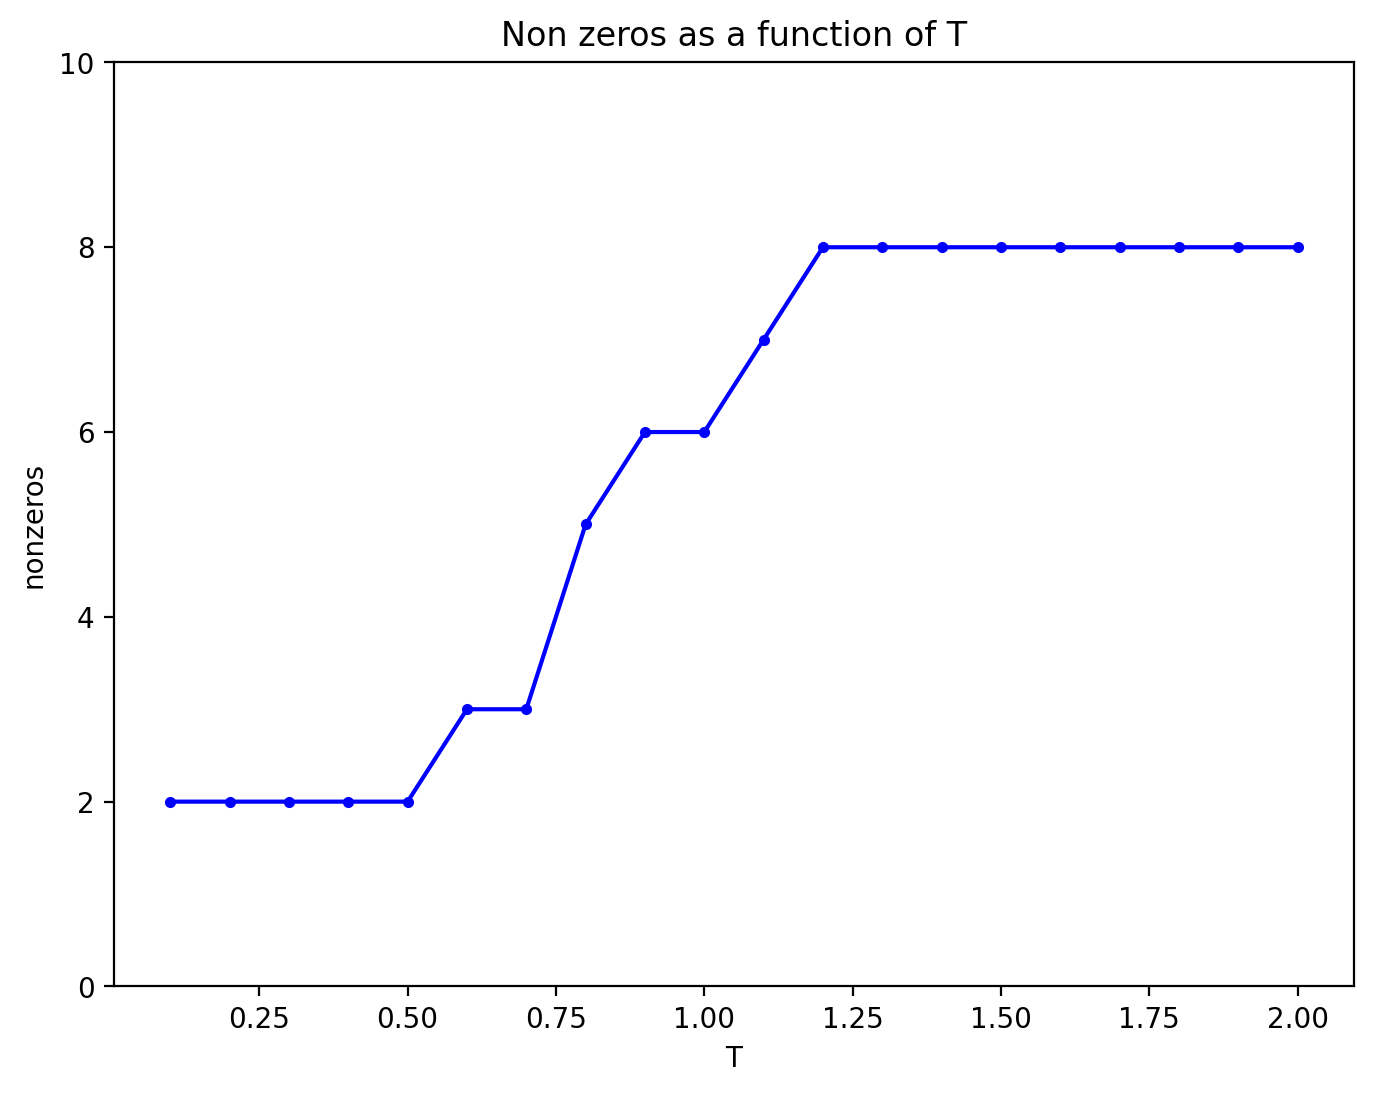

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

Tval = m['Tval'].records.value
nnz = m['nnz'].records.value

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title("Non zeros as a function of T")
ax.set_xlabel("T")
ax.set_ylabel("nonzeros")
ax.plot(Tval,nnz,"b.-")
ax.set_ylim([0,10]);

# Additional material
 - O.L. Mangasarian was a professor at UW-Madison and has several talks on optimization, data vectors, classification and support vector machines. Specifially his Arbitrary-Norm Separating Plane and Generalized Support Vector Machines talks may be helpful. http://pages.cs.wisc.edu/~olvi/
 - Another helpful background source: "Why $\ell_1$ is a good approximation to $\ell_0$: A geometric explanation" by C. Ramierz, V. Kreinovich, and M. Aragez. http://www.cs.utep.edu/vladik/2013/tr13-18.pdf
 - An introduction to support vector machines and related kernel methods: "Learning with Kernels" by B. Schölkopf and A. Smola. https://mitpress.mit.edu/books/learning-kernels
 - "A closer look at sparse regression" by R.J. Tibshirani https://www.stat.cmu.edu/~larry/=sml/sparsity.pdf

In [13]:
%gams_cleanup --closedown